In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import xgboost

In [25]:
import pickle

In [26]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716230354427, experiment_id='1', last_update_time=1716230354427, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [27]:
def read_data(filename, pickup_time_column, dropoff_time_column, filter_data=True):
    df = pd.read_parquet(filename)
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    df['duration'] = pd.to_datetime(df[dropoff_time_column]) - pd.to_datetime(df[pickup_time_column])
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    if filter_data:
        df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df

In [28]:
def pre_process_data(df):
    
    df['PO_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    categorical = ['PO_DO'] #['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    x_dict = df[categorical + numerical].to_dict(orient='records')
    
    target = 'duration'
    y = df[target].values
    
    return x_dict, y

In [29]:
dv = DictVectorizer()

df_train = read_data('../data/green_tripdata_2021-01.parquet', 'lpep_pickup_datetime', 'lpep_dropoff_datetime')
train_dict, y_train = pre_process_data(df_train)
x_train = dv.fit_transform(train_dict)

df_val = read_data('../data/green_tripdata_2021-02.parquet', 'lpep_pickup_datetime', 'lpep_dropoff_datetime')
val_dict, y_val = pre_process_data(df_val)
x_val = dv.transform(val_dict)

In [8]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


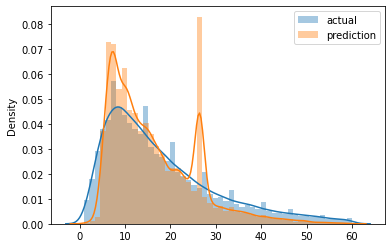

In [9]:
y_pred = lr.predict(x_val)
sns.distplot(y_val, label='actual')
sns.distplot(y_pred, label='prediction')
plt.legend()

In [10]:
mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

In [20]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


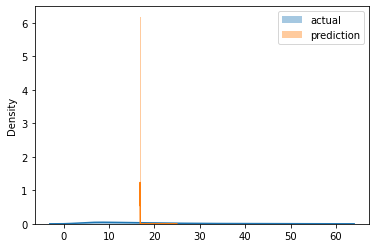

In [21]:
with mlflow.start_run():

    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "../data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    ls = Lasso()
    ls.fit(x_train, y_train)
    y_pred = ls.predict(x_val)
    sns.distplot(y_val, label='actual')
    sns.distplot(y_pred, label='prediction')
    plt.legend()
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models_pickle")

In [36]:
with mlflow.start_run():
    
    best_params = {
        'learning_rate': 0.09,
        'max_depth': 30,
        'min_child_weight': 1.06,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.018,
        'reg_lambda': 0.012,
        'seed': 42
    }
    
    mlflow.log_params(best_params)
    
    with open('../models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")
    
    train_data = xgboost.DMatrix(x_train, y_train)
    valid_data = xgboost.DMatrix(x_val, y_val)
    
    booster = xgboost.train(
        params=best_params,
        dtrain=train_data,
        num_boost_round=500,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=50)
    
    y_pred = booster.predict(valid_data)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:11.49106
[1]	validation-rmse:10.85344
[2]	validation-rmse:10.28981
[3]	validation-rmse:9.79734
[4]	validation-rmse:9.36571
[5]	validation-rmse:8.98756
[6]	validation-rmse:8.65993
[7]	validation-rmse:8.37423
[8]	validation-rmse:8.12751
[9]	validation-rmse:7.91580
[10]	validation-rmse:7.73098
[11]	validation-rmse:7.57449
[12]	validation-rmse:7.43693
[13]	validation-rmse:7.31942
[14]	validation-rmse:7.21679
[15]	validation-rmse:7.12967
[16]	validation-rmse:7.05452
[17]	validation-rmse:6.98939
[18]	validation-rmse:6.93377
[19]	validation-rmse:6.88493
[20]	validation-rmse:6.84241
[21]	validation-rmse:6.80535
[22]	validation-rmse:6.77328
[23]	validation-rmse:6.74452
[24]	validation-rmse:6.71941
[25]	validation-rmse:6.69706
[26]	validation-rmse:6.67742
[27]	validation-rmse:6.66056
[28]	validation-rmse:6.64508
[29]	validation-rmse:6.63159
[30]	validation-rmse:6.61981
[31]	validation-rmse:6.60865
[32]	validation-rmse:6.59843
[33]	validation-rmse:6.58967
[34]	validation-rmse:

[277]	validation-rmse:6.40998
[278]	validation-rmse:6.40970
[279]	validation-rmse:6.40953
[280]	validation-rmse:6.40899
[281]	validation-rmse:6.40878
[282]	validation-rmse:6.40843
[283]	validation-rmse:6.40832
[284]	validation-rmse:6.40815
[285]	validation-rmse:6.40791
[286]	validation-rmse:6.40763
[287]	validation-rmse:6.40728
[288]	validation-rmse:6.40693
[289]	validation-rmse:6.40665
[290]	validation-rmse:6.40634
[291]	validation-rmse:6.40617
[292]	validation-rmse:6.40584
[293]	validation-rmse:6.40510
[294]	validation-rmse:6.40476
[295]	validation-rmse:6.40439
[296]	validation-rmse:6.40422
[297]	validation-rmse:6.40390
[298]	validation-rmse:6.40354
[299]	validation-rmse:6.40325
[300]	validation-rmse:6.40307
[301]	validation-rmse:6.40284
[302]	validation-rmse:6.40260
[303]	validation-rmse:6.40255
[304]	validation-rmse:6.40237
[305]	validation-rmse:6.40204
[306]	validation-rmse:6.40170
[307]	validation-rmse:6.40159
[308]	validation-rmse:6.40137
[309]	validation-rmse:6.40114
[310]	vali

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:59:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## Loading Models

In [37]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [39]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716230354427, experiment_id='1', last_update_time=1716230354427, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/0', creation_time=1716230354398, experiment_id='0', last_update_time=1716230354398, lifecycle_stage='active', name='Default', tags={}>]

In [41]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"])

runs

[<Run: data=<RunData: metrics={'rmse': 6.365150129739202}, params={'learning_rate': '0.09',
  'max_depth': '30',
  'min_child_weight': '1.06',
  'objective': 'reg:squarederror',
  'reg_alpha': '0.018',
  'reg_lambda': '0.012',
  'seed': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "8fcdf86f121b48b4b5537c46185a6156", '
                              '"artifact_path": "models_mlflow", '
                              '"utc_time_created": "2024-05-26 '
                              '05:59:04.544454", "flavors": {"python_function": '
                              '{"loader_module": "mlflow.xgboost", '
                              '"python_version": "3.9.12", "data": "model.xgb", '
                              '"env": {"conda": "conda.yaml", "virtualenv": '
                              '"python_env.yaml"}}, "xgboost": {"xgb_version": '
                              '"2.0.3", "data": "model.xgb", "model_class": '
                              '"xgboost.core.Booster", "model_format"

In [19]:
filtered_df = read_data(
    '../data/yellow_tripdata_2023-01.parquet',
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime')
len(filtered_df) / len(df)

0.9812202822125979

In [27]:
categorical = ['PULocationID', 'DOLocationID']
features = filtered_df[categorical].to_dict(orient='records')
dv = DictVectorizer()
features = dv.fit_transform(features)
features

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [28]:
labels = filtered_df.duration
lr = LinearRegression()
lr.fit(features, labels)
y_pred = lr.predict(features)
mean_squared_error(labels, y_pred, squared=False)

7.6492610279057605

In [30]:
df_val = read_data(
    '../data/yellow_tripdata_2023-02.parquet',
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime')
features_val = df_val[categorical].to_dict(orient='records')
features_val = dv.transform(features_val)
labels_val = df_val.duration
lr.predict(features_val)
y_val = lr.predict(features_val)
mean_squared_error(labels_val, y_val, squared=False)

7.81183265470218

In [25]:
features

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>